## **Install Necessary Packages**
 - Always run this when starting the notebook

In [1]:
from netCDF4 import Dataset, num2date, date2num
import csv
import time
import glob
import xarray as xr 
import seaborn as sns
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, vertcross,
                 cartopy_ylim, interplevel, latlon_coords, uvmet, CoordPair,
                ALL_TIMES)
from matplotlib.dates import MonthLocator
import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import dask.array as da
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker
import cartopy.mpl.ticker as cticker
from matplotlib.cm import get_cmap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
Saved_Data_Path =  r'/glade/u/home/mwarms/SavedData/'
SNOWIE_Data_Path = r'/glade/u/home/mwarms/SNOWIE_Seasonal_Data/wrfout_d02'
Scratch_Path = r'/glade/scratch/mwarms/temp/'

## **Load Event Indices & Projection Info & Z_bins**
- previously saved as CSVs

In [3]:
MonthlyLastTimestep = [0, 744, 1463, 2207, 2951, 3623, 4367, 5087]
Months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]
EventsPerMonth = [17, 11, 11, 12, 9, 12, 15]
EventCountsPerMonth = [17, 28, 39, 51, 60, 72, 87]

with open(Saved_Data_Path + 'EventLengths.csv') as f:
    reader = csv.reader(f)
    EventLengths = list(reader)
EventLengths = EventLengths[0]
EventLengths = [int(i) for i in EventLengths]

with open(Saved_Data_Path + 'EventTimesStart.csv') as f:
    reader = csv.reader(f)
    EventTimesStart = list(reader)
EventTimesStart = EventTimesStart[0]
EventTimesStart = [int(i) for i in EventTimesStart]

with open(Saved_Data_Path + 'EventTimesEnd.csv') as f:
    reader = csv.reader(f)
    EventTimesEnd = list(reader)
EventTimesEnd = EventTimesEnd[0]
EventTimesEnd = [int(i) for i in EventTimesEnd]

with open(Saved_Data_Path + 'SnowfallEventNumbered.csv') as f:
    reader = csv.reader(f)
    SnowfallEventNumbered = list(reader)
SnowfallEventNumbered = SnowfallEventNumbered[0]
SnowfallEventNumbered = [int(float(i)) for i in SnowfallEventNumbered]

with open(Saved_Data_Path + 'MonthlyEventIndices.csv') as f:
    reader = csv.reader(f)
    MonthlyEventIndices = list(reader)
MonthlyEventIndices = MonthlyEventIndices[0]
MonthlyEventIndices = [int(i) for i in MonthlyEventIndices]

z_bins = np.genfromtxt(Saved_Data_Path + 'z_bins.csv', delimiter = ",")

EventPrecip = np.genfromtxt(Saved_Data_Path + 'EventPrecip.csv', delimiter = ",")

In [4]:
# Save big files to disk then delete for memory purposes
def write_xarray_to_netcdf(xarray_array, output_path,mode='w', format='NETCDF4', group=None, engine=None,
                           encoding=None):
    """writes and xarray in a netcdf format outputfile
    Uses the xarray typical for wrf-python. The projection objects are transformed into strings
    to be able to use them as netcdf attributes
    :param xarray_array: xarray.DataArray
    :param output_path: str
    :param format: 'NETCDF4', 'NETCDF4_CLASSIC', 'NETCDF3_64BIT' or 'NETCDF3_CLASSIC'
                    default: 'NETCDF4'
    :param group: str, default None
    :param engine: 'netcdf4', 'scipy' or 'h5netcdf'
    :param encoding: dict, default: None
    """
    xarray_array_out = xarray_array.copy(deep=True)
    # coordinates are extracted from variable
    # del xarray_array_out.attrs['coordinates']
    # wrf-python projection object cannot be processed
    # xarray_array_out.attrs['projection'] = str(xarray_array_out.attrs['projection'])

    xarray_array_out.to_netcdf(path=output_path, mode=mode, format=format, group=group,
                               engine=engine,
                               encoding=encoding)

## Load Vars from Scratch

- **Load QVAPOR**

In [35]:
# Scratch Paths for QVAPOR by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QVAPOR_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QVAPOR_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QVAPOR_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QVAPOR_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QVAPOR_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QVAPOR_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QVAPOR_snowie_apr.nc'

# Load QVAPORs
QVAPOR_snowie_oct = xr.open_dataarray(Oct_Path)
QVAPOR_snowie_nov = xr.open_dataarray(Nov_Path)
QVAPOR_snowie_dec = xr.open_dataarray(Dec_Path)
QVAPOR_snowie_jan = xr.open_dataarray(Jan_Path)
QVAPOR_snowie_feb = xr.open_dataarray(Feb_Path)
QVAPOR_snowie_mar = xr.open_dataarray(Mar_Path)
QVAPOR_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load U**

In [6]:
# Scratch Paths for u by month
Oct_Path =  r'/glade/scratch/mwarms/temp/u_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/u_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/u_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/u_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/u_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/u_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/u_snowie_apr.nc'

# Load us
u_snowie_oct = xr.open_dataarray(Oct_Path)
u_snowie_nov = xr.open_dataarray(Nov_Path)
u_snowie_dec = xr.open_dataarray(Dec_Path)
u_snowie_jan = xr.open_dataarray(Jan_Path)
u_snowie_feb = xr.open_dataarray(Feb_Path)
u_snowie_mar = xr.open_dataarray(Mar_Path)
u_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load V**

In [7]:
# Scratch Paths for v by month
Oct_Path =  r'/glade/scratch/mwarms/temp/v_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/v_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/v_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/v_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/v_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/v_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/v_snowie_apr.nc'

# Load vs
v_snowie_oct = xr.open_dataarray(Oct_Path)
v_snowie_nov = xr.open_dataarray(Nov_Path)
v_snowie_dec = xr.open_dataarray(Dec_Path)
v_snowie_jan = xr.open_dataarray(Jan_Path)
v_snowie_feb = xr.open_dataarray(Feb_Path)
v_snowie_mar = xr.open_dataarray(Mar_Path)
v_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load P**

In [8]:
# Scratch Paths for v by month
Oct_Path =  r'/glade/scratch/mwarms/temp/p_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/p_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/p_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/p_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/p_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/p_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/p_snowie_apr.nc'

# Load vs
p_snowie_oct = xr.open_dataarray(Oct_Path)
p_snowie_nov = xr.open_dataarray(Nov_Path)
p_snowie_dec = xr.open_dataarray(Dec_Path)
p_snowie_jan = xr.open_dataarray(Jan_Path)
p_snowie_feb = xr.open_dataarray(Feb_Path)
p_snowie_mar = xr.open_dataarray(Mar_Path)
p_snowie_apr = xr.open_dataarray(Apr_Path)

- **Load z**

In [9]:
# Scratch Paths for z by month
Oct_Path =  r'/glade/scratch/mwarms/temp/z_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/z_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/z_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/z_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/z_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/z_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/z_snowie_apr.nc'

# Load zs
z_snowie_oct = xr.open_dataarray(Oct_Path)
z_snowie_nov = xr.open_dataarray(Nov_Path)
z_snowie_dec = xr.open_dataarray(Dec_Path)
z_snowie_jan = xr.open_dataarray(Jan_Path)
z_snowie_feb = xr.open_dataarray(Feb_Path)
z_snowie_mar = xr.open_dataarray(Mar_Path)
z_snowie_apr = xr.open_dataarray(Apr_Path)

## Calculate IVT for All Months

- **Oct**

In [5]:
# Initialize Empty Arrays (time, x, y)
IVT_x_oct = np.zeros([744,388,540])
IVT_y_oct = np.zeros([744,388,540])
IVT_oct = np.zeros([744,388,540])

# loop through time
for t in range (0, 744):

    # loop through 80 pressure levels (1 minutes total = 80 - 1 = 79)
    for z in range(0, 79):

        IVT_x_oct[t] = IVT_x_oct[t] + (100 * (p_snowie_oct[t,z] - p_snowie_oct[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_oct[t,z] + QVAPOR_snowie_oct[t,z+1]) / 2) *   # average q within pressure level
                                      ((u_snowie_oct[t,z] + u_snowie_oct[t,z+1]) / 2)) / 9.81       # average u within pressure level / g

        IVT_y_oct[t] = IVT_y_oct[t] + (100 * (p_snowie_oct[t,z] - p_snowie_oct[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_oct[t,z] + QVAPOR_snowie_oct[t,z+1]) / 2) *   # average q within pressure level
                                      ((v_snowie_oct[t,z] + v_snowie_oct[t,z+1]) / 2)) / 9.81       # average v within pressure level / g

IVT_oct = (IVT_x_oct ** 2 + IVT_y_oct ** 2) ** 0.5  # pythag thm

del IVT_x_oct, IVT_y_oct

In [ ]:
IVT_oct_da = xr.DataArray(
                  data = IVT_oct,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_oct[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_oct[0].XLAT.data),
                      time = p_snowie_oct.Time.data,
                      reference_time = p_snowie_oct[0].Time.data
                  ),
                  attrs = dict(
                      description = "Integrated Water Vapor Content.",
                      units = "kg m-1 s-1",
                  ),
                         )

In [48]:
# Save to Scratch
write_xarray_to_netcdf(IVT_oct_da, Scratch_Path + "IVT_oct.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

del IVT_oct, IVT_oct_da

- **Nov**

In [10]:
IVT_x_nov = np.zeros([719,388,540])
IVT_y_nov = np.zeros([719,388,540])
IVT_nov = np.zeros([719,388,540])

# loop through time
for t in range (0, 719):

    # loop through 80 pressure levels (1 minutes total = 80 - 1 = 79)
    for z in range(0, 79):

        IVT_x_nov[t] = IVT_x_nov[t] + (100 * (p_snowie_nov[t,z] - p_snowie_nov[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_nov[t,z] + QVAPOR_snowie_nov[t,z+1]) / 2) *   # average q within pressure level
                                      ((u_snowie_nov[t,z] + u_snowie_nov[t,z+1]) / 2)) / 9.81       # average u within pressure level / g

        IVT_y_nov[t] = IVT_y_nov[t] + (100 * (p_snowie_nov[t,z] - p_snowie_nov[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_nov[t,z] + QVAPOR_snowie_nov[t,z+1]) / 2) *   # average q within pressure level
                                      ((v_snowie_nov[t,z] + v_snowie_nov[t,z+1]) / 2)) / 9.81       # average v within pressure level / g

IVT_nov = (IVT_x_nov ** 2 + IVT_y_nov ** 2) ** 0.5  # pythag thm

del IVT_x_nov, IVT_y_nov

In [12]:
IVT_nov_da = xr.DataArray(
                  data = IVT_nov,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_nov[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_nov[0].XLAT.data),
                      time = p_snowie_nov.Time.data,
                      reference_time = p_snowie_nov[0].Time.data
                  ),
                  attrs = dict(
                      description = "Integrated Water Vapor Content.",
                      units = "kg m-1 s-1",
                  ),
                         )

In [13]:
# Save to Scratch
write_xarray_to_netcdf(IVT_nov_da, Scratch_Path + "IVT_nov.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

del IVT_nov, IVT_nov_da

- **Dec**

In [19]:
IVT_x_dec = np.zeros([744,388,540])
IVT_y_dec = np.zeros([744,388,540])
IVT_dec = np.zeros([744,388,540])

# loop through time
for t in range (0, 744):

    # loop through 80 pressure levels (1 minutes total = 80 - 1 = 79)
    for z in range(0, 79):

        IVT_x_dec[t] = IVT_x_dec[t] + (100 * (p_snowie_dec[t,z] - p_snowie_dec[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_dec[t,z] + QVAPOR_snowie_dec[t,z+1]) / 2) *   # average q within pressure level
                                      ((u_snowie_dec[t,z] + u_snowie_dec[t,z+1]) / 2)) / 9.81       # average u within pressure level / g

        IVT_y_dec[t] = IVT_y_dec[t] + (100 * (p_snowie_dec[t,z] - p_snowie_dec[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_dec[t,z] + QVAPOR_snowie_dec[t,z+1]) / 2) *   # average q within pressure level
                                      ((v_snowie_dec[t,z] + v_snowie_dec[t,z+1]) / 2)) / 9.81       # average v within pressure level / g

IVT_dec = (IVT_x_dec ** 2 + IVT_y_dec ** 2) ** 0.5  # pythag thm

del IVT_x_dec, IVT_y_dec

In [21]:
IVT_dec_da = xr.DataArray(
                  data = IVT_dec,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_dec[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_dec[0].XLAT.data),
                      time = p_snowie_dec.Time.data,
                      reference_time = p_snowie_dec[0].Time.data
                  ),
                  attrs = dict(
                      description = "Integrated Water Vapor Content.",
                      units = "kg m-1 s-1",
                  ),
                         )

In [23]:
# Save to Scratch
write_xarray_to_netcdf(IVT_dec_da, Scratch_Path + "IVT_dec.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

del IVT_dec, IVT_dec_da

- **Jan**

In [25]:
IVT_x_jan = np.zeros([744,388,540])
IVT_y_jan = np.zeros([744,388,540])
IVT_jan = np.zeros([744,388,540])

# loop through time
for t in range (0, 744):

    # loop through 80 pressure levels (1 minutes total = 80 - 1 = 79)
    for z in range(0, 79):

        IVT_x_jan[t] = IVT_x_jan[t] + (100 * (p_snowie_jan[t,z] - p_snowie_jan[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_jan[t,z] + QVAPOR_snowie_jan[t,z+1]) / 2) *   # average q within pressure level
                                      ((u_snowie_jan[t,z] + u_snowie_jan[t,z+1]) / 2)) / 9.81       # average u within pressure level / g

        IVT_y_jan[t] = IVT_y_jan[t] + (100 * (p_snowie_jan[t,z] - p_snowie_jan[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_jan[t,z] + QVAPOR_snowie_jan[t,z+1]) / 2) *   # average q within pressure level
                                      ((v_snowie_jan[t,z] + v_snowie_jan[t,z+1]) / 2)) / 9.81       # average v within pressure level / g

IVT_jan = (IVT_x_jan ** 2 + IVT_y_jan ** 2) ** 0.5  # pythag thm

del IVT_x_jan, IVT_y_jan

In [27]:
IVT_jan_da = xr.DataArray(
                  data = IVT_jan,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_jan[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_jan[0].XLAT.data),
                      time = p_snowie_jan.Time.data,
                      reference_time = p_snowie_jan[0].Time.data
                  ),
                  attrs = dict(
                      description = "Integrated Water Vapor Content.",
                      units = "kg m-1 s-1",
                  ),
                         )

In [29]:
# Save to Scratch
write_xarray_to_netcdf(IVT_jan_da, Scratch_Path + "IVT_jan.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

del IVT_jan, IVT_jan_da

- **Feb**

In [31]:
IVT_x_feb = np.zeros([672,388,540])
IVT_y_feb = np.zeros([672,388,540])
IVT_feb = np.zeros([672,388,540])

# loop through time
for t in range (0, 672):

    # loop through 80 pressure levels (1 minutes total = 80 - 1 = 79)
    for z in range(0, 79):

        IVT_x_feb[t] = IVT_x_feb[t] + (100 * (p_snowie_feb[t,z] - p_snowie_feb[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_feb[t,z] + QVAPOR_snowie_feb[t,z+1]) / 2) *   # average q within pressure level
                                      ((u_snowie_feb[t,z] + u_snowie_feb[t,z+1]) / 2)) / 9.81       # average u within pressure level / g

        IVT_y_feb[t] = IVT_y_feb[t] + (100 * (p_snowie_feb[t,z] - p_snowie_feb[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_feb[t,z] + QVAPOR_snowie_feb[t,z+1]) / 2) *   # average q within pressure level
                                      ((v_snowie_feb[t,z] + v_snowie_feb[t,z+1]) / 2)) / 9.81       # average v within pressure level / g

IVT_feb = (IVT_x_feb ** 2 + IVT_y_feb ** 2) ** 0.5  # pythag thm

del IVT_x_feb, IVT_y_feb

In [33]:
IVT_feb_da = xr.DataArray(
                  data = IVT_feb,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_feb[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_feb[0].XLAT.data),
                      time = p_snowie_feb.Time.data,
                      reference_time = p_snowie_feb[0].Time.data
                  ),
                  attrs = dict(
                      description = "Integrated Water Vapor Content.",
                      units = "kg m-1 s-1",
                  ),
                         )

In [35]:
# Save to Scratch
write_xarray_to_netcdf(IVT_feb_da, Scratch_Path + "IVT_feb.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

del IVT_feb, IVT_feb_da

- **Mar**

In [37]:
IVT_x_mar = np.zeros([744,388,540])
IVT_y_mar = np.zeros([744,388,540])
IVT_mar = np.zeros([744,388,540])

# loop through time
for t in range (0, 744):

    # loop through 80 pressure levels (1 minutes total = 80 - 1 = 79)
    for z in range(0, 79):

        IVT_x_mar[t] = IVT_x_mar[t] + (100 * (p_snowie_mar[t,z] - p_snowie_mar[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_mar[t,z] + QVAPOR_snowie_mar[t,z+1]) / 2) *   # average q within pressure level
                                      ((u_snowie_mar[t,z] + u_snowie_mar[t,z+1]) / 2)) / 9.81       # average u within pressure level / g

        IVT_y_mar[t] = IVT_y_mar[t] + (100 * (p_snowie_mar[t,z] - p_snowie_mar[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_mar[t,z] + QVAPOR_snowie_mar[t,z+1]) / 2) *   # average q within pressure level
                                      ((v_snowie_mar[t,z] + v_snowie_mar[t,z+1]) / 2)) / 9.81       # average v within pressure level / g

IVT_mar = (IVT_x_mar ** 2 + IVT_y_mar ** 2) ** 0.5  # pythag thm

del IVT_x_mar, IVT_y_mar

In [39]:
IVT_mar_da = xr.DataArray(
                  data = IVT_mar,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_mar[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_mar[0].XLAT.data),
                      time = p_snowie_mar.Time.data,
                      reference_time = p_snowie_mar[0].Time.data
                  ),
                  attrs = dict(
                      description = "Integrated Water Vapor Content.",
                      units = "kg m-1 s-1",
                  ),
                         )

In [40]:
# Save to Scratch
write_xarray_to_netcdf(IVT_mar_da, Scratch_Path + "IVT_mar.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

del IVT_mar, IVT_mar_da

- **Apr**

In [41]:
IVT_x_apr = np.zeros([720,388,540])
IVT_y_apr = np.zeros([720,388,540])
IVT_apr = np.zeros([720,388,540])

# loop through time
for t in range (0, 720):

    # loop through 80 pressure levels (1 minutes total = 80 - 1 = 79)
    for z in range(0, 79):

        IVT_x_apr[t] = IVT_x_apr[t] + (100 * (p_snowie_apr[t,z] - p_snowie_apr[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_apr[t,z] + QVAPOR_snowie_apr[t,z+1]) / 2) *   # average q within pressure level
                                      ((u_snowie_apr[t,z] + u_snowie_apr[t,z+1]) / 2)) / 9.81       # average u within pressure level / g

        IVT_y_apr[t] = IVT_y_apr[t] + (100 * (p_snowie_apr[t,z] - p_snowie_apr[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                                      ((QVAPOR_snowie_apr[t,z] + QVAPOR_snowie_apr[t,z+1]) / 2) *   # average q within pressure level
                                      ((v_snowie_apr[t,z] + v_snowie_apr[t,z+1]) / 2)) / 9.81       # average v within pressure level / g

IVT_apr = (IVT_x_apr ** 2 + IVT_y_apr ** 2) ** 0.5  # pythag thm

del IVT_x_apr, IVT_y_apr

In [42]:
IVT_apr_da = xr.DataArray(
                  data = IVT_apr,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_apr[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_apr[0].XLAT.data),
                      time = p_snowie_apr.Time.data,
                      reference_time = p_snowie_oct[0].Time.data
                  ),
                  attrs = dict(
                      description = "Integrated Water Vapor Content.",
                      units = "kg m-1 s-1",
                  ),
                         )

In [43]:
# Save to Scratch
write_xarray_to_netcdf(IVT_apr_da, Scratch_Path + "IVT_apr.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

del IVT_apr, IVT_apr_da

## Calculate IVT for Events Only

- **Load IVT data from Scratch**

In [7]:
# Scratch Paths for IVT by month
Oct_Path =  r'/glade/scratch/mwarms/temp/IVT_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/IVT_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/IVT_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/IVT_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/IVT_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/IVT_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/IVT_apr.nc'

# Load QVAPORs
IVT_oct = xr.open_dataarray(Oct_Path)
IVT_nov = xr.open_dataarray(Nov_Path)
IVT_dec = xr.open_dataarray(Dec_Path)
IVT_jan = xr.open_dataarray(Jan_Path)
IVT_feb = xr.open_dataarray(Feb_Path)
IVT_mar = xr.open_dataarray(Mar_Path)
IVT_apr = xr.open_dataarray(Apr_Path)

- Create Chunked Datasets

In [8]:
IVT_oct_chunked = IVT_oct.chunk({'time':24})
IVT_nov_chunked = IVT_nov.chunk({'time':24})
IVT_dec_chunked = IVT_dec.chunk({'time':24})
IVT_jan_chunked = IVT_jan.chunk({'time':24})
IVT_feb_chunked = IVT_feb.chunk({'time':24})
IVT_mar_chunked = IVT_mar.chunk({'time':24})
IVT_apr_chunked = IVT_apr.chunk({'time':24})

In [9]:
IVT_chunked = xr.concat([IVT_oct_chunked, IVT_nov_chunked, IVT_dec_chunked, 
                         IVT_jan_chunked, IVT_feb_chunked, IVT_mar_chunked, IVT_apr_chunked], dim = 'time')

In [10]:
IVT_chunked

<xarray.DataArray (time: 5087, south_north: 388, west_east: 540)>
dask.array<concatenate, shape=(5087, 388, 540), dtype=float64, chunksize=(24, 388, 540), chunktype=numpy.ndarray>
Coordinates:
    XLONG           (south_north, west_east) float32 -117.0 -117.0 ... -110.7
    XLAT            (south_north, west_east) float32 43.01 43.01 ... 45.98 45.98
  * time            (time) datetime64[ns] 2016-10-01 ... 2017-04-30T23:00:00
    reference_time  (time) datetime64[ns] 2016-10-01 2016-10-01 ... 2016-10-01
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  Integrated Water Vapor Content.
    units:        kg m-1 s-1

- Monthly Average IVT

In [11]:
Monthly_Avg_IVT = np.zeros(7)
Monthly_Avg_IVT[0] = IVT_oct_chunked.mean().compute()
Monthly_Avg_IVT[1] = IVT_nov_chunked.mean().compute()
Monthly_Avg_IVT[2] = IVT_dec_chunked.mean().compute()
Monthly_Avg_IVT[3] = IVT_jan_chunked.mean().compute()
Monthly_Avg_IVT[4] = IVT_feb_chunked.mean().compute()
Monthly_Avg_IVT[5] = IVT_mar_chunked.mean().compute()
Monthly_Avg_IVT[6] = IVT_apr_chunked.mean().compute()

In [12]:
print("Average Monthly IVT in...", end = " "),
for i in range(0,len(Monthly_Avg_IVT)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_IVT[i]), "kg m-1 s-1", end = "; "),

Average Monthly IVT in... Oct = 132.242 kg m-1 s-1; Nov = 79.718 kg m-1 s-1; Dec = 73.357 kg m-1 s-1; Jan = 59.312 kg m-1 s-1; Feb = 100.529 kg m-1 s-1; Mar = 108.955 kg m-1 s-1; Apr = 74.652 kg m-1 s-1; 

- Monthly Max IVT

In [13]:
Monthly_Max_IVT = np.zeros(7)
Monthly_Max_IVT[0] = IVT_oct_chunked.max().compute()
Monthly_Max_IVT[1] = IVT_nov_chunked.max().compute()
Monthly_Max_IVT[2] = IVT_dec_chunked.max().compute()
Monthly_Max_IVT[3] = IVT_jan_chunked.max().compute()
Monthly_Max_IVT[4] = IVT_feb_chunked.max().compute()
Monthly_Max_IVT[5] = IVT_mar_chunked.max().compute()
Monthly_Max_IVT[6] = IVT_apr_chunked.max().compute()

In [14]:
print("Max Monthly IVT in...", end = " "),
for i in range(0,len(Monthly_Max_IVT)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Max_IVT[i]), "kg m-1 s-1", end = "; "),

Max Monthly IVT in... Oct = 848.851 kg m-1 s-1; Nov = 528.393 kg m-1 s-1; Dec = 474.006 kg m-1 s-1; Jan = 565.096 kg m-1 s-1; Feb = 643.668 kg m-1 s-1; Mar = 586.340 kg m-1 s-1; Apr = 538.906 kg m-1 s-1; 

In [15]:
IVT_events = IVT_chunked * np.nan
# IVT_non_events = IVT_chunked

for j in range(0,len(EventTimesStart)):
    IVT_events[EventTimesStart[j]:EventTimesEnd[j]] = IVT_chunked[EventTimesStart[j]:EventTimesEnd[j]]
    # IVT_non_events[EventTimesStart[j]:EventTimesEnd[j]] = IVT_chunked[EventTimesStart[j]:EventTimesEnd[j]] * np.nan

In [16]:
IVT_events.mean().compute()

<xarray.DataArray ()>
array(103.82536181)

In [17]:
IVT_events_monthly = IVT_events.resample(time = '1M').mean(dim = 'time').compute()
IVT_events_max_monthly = IVT_events.resample(time = '1M').max(dim = 'time').compute()
# IVT_non_events_monthly = IVT_non_events.resample(time = '1M').mean(dim = 'time').compute()

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


- Monthly Average IVT during Events

In [18]:
Monthly_Avg_IVT_events = np.zeros(7)
Monthly_Avg_IVT_events[0] = IVT_events_monthly[0].mean().compute()
Monthly_Avg_IVT_events[1] = IVT_events_monthly[1].mean().compute()
Monthly_Avg_IVT_events[2] = IVT_events_monthly[2].mean().compute()
Monthly_Avg_IVT_events[3] = IVT_events_monthly[3].mean().compute()
Monthly_Avg_IVT_events[4] = IVT_events_monthly[4].mean().compute()
Monthly_Avg_IVT_events[5] = IVT_events_monthly[5].mean().compute()
Monthly_Avg_IVT_events[6] = IVT_events_monthly[6].mean().compute()

In [19]:
print("Average Monthly IVT during events in...", end = " "),
for i in range(0,len(Monthly_Avg_IVT_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_IVT_events[i]), "kg m-1 s-1", end = "; "),

Average Monthly IVT during events in... Oct = 131.116 kg m-1 s-1; Nov = 97.204 kg m-1 s-1; Dec = 103.065 kg m-1 s-1; Jan = 81.694 kg m-1 s-1; Feb = 122.054 kg m-1 s-1; Mar = 117.959 kg m-1 s-1; Apr = 75.801 kg m-1 s-1; 

- Monthly Max 

In [22]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

Monthly_Max_IVT_events = np.zeros(7)
Monthly_Max_IVT_events[0] = IVT_events[MonthlyLastTimestep[0]:MonthlyLastTimestep[1]].max().compute()
Monthly_Max_IVT_events[1] = IVT_events[MonthlyLastTimestep[1]:MonthlyLastTimestep[2]].max().compute()
Monthly_Max_IVT_events[2] = IVT_events[MonthlyLastTimestep[2]:MonthlyLastTimestep[3]].max().compute()
Monthly_Max_IVT_events[3] = IVT_events[MonthlyLastTimestep[3]:MonthlyLastTimestep[4]].max().compute()
Monthly_Max_IVT_events[4] = IVT_events[MonthlyLastTimestep[4]:MonthlyLastTimestep[5]].max().compute()
Monthly_Max_IVT_events[5] = IVT_events[MonthlyLastTimestep[5]:MonthlyLastTimestep[6]].max().compute()
Monthly_Max_IVT_events[6] = IVT_events[MonthlyLastTimestep[6]:MonthlyLastTimestep[7]].max().compute()

In [23]:
print("Max Monthly IVT in...", end = " "),
for i in range(0,len(Monthly_Max_IVT_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Max_IVT_events[i]), "kg m-1 s-1", end = "; "),

Max Monthly IVT in... Oct = 848.851 kg m-1 s-1; Nov = 491.522 kg m-1 s-1; Dec = 474.006 kg m-1 s-1; Jan = 565.096 kg m-1 s-1; Feb = 643.668 kg m-1 s-1; Mar = 421.835 kg m-1 s-1; Apr = 480.278 kg m-1 s-1; 

## Initial Plots

- When is the max snowfall?

In [24]:
print("Index: ", np.where(EventPrecip == EventPrecip.max()))

Index:  (array([44]),)


In [25]:
EventTimesStart[44], EventTimesEnd[44]

(2393, 2484)

- **Oct:** [0:744] => [0:744]
- **Nov:** [0:719] => [744:1464]
- **Dec:** [0:744] => [1464:2208]
- **Jan:** [0:744] => [2208:2952]
- **Feb:** [0:672] => [2952:3624]
- **Mar:** [0:744] => [3624:4368]
- **Apr:** [0:720] => [4368:5088]

In [26]:
## Isolate the Max Snowfall Event:
MaxSnowfallTimesStart = EventTimesStart[44] - 2208
MaxSnowfallTimesEnd = EventTimesEnd[44] - 2208

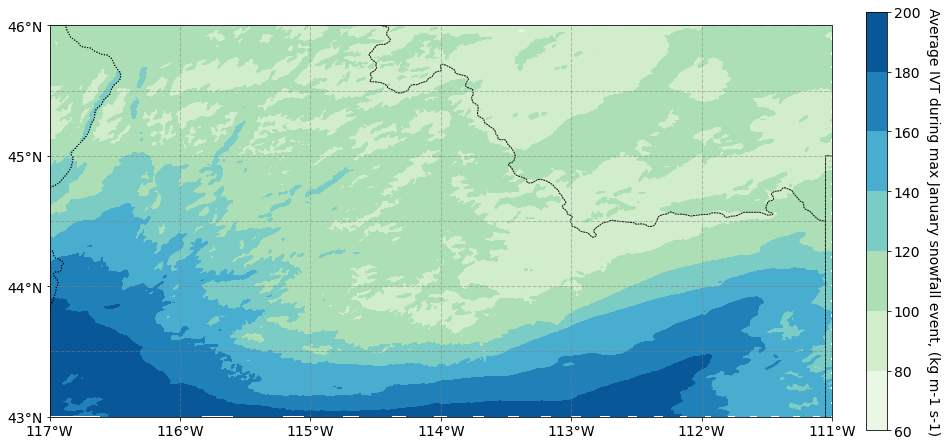

In [27]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(IVT_jan)

# Setup figure and projection
fig = plt.figure(figsize = (15,8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, IVT_jan[MaxSnowfallTimesStart:MaxSnowfallTimesEnd].mean('time'), cmap=get_cmap("GnBu"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
ax.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
ax.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax.set_ylim([43,46])
ax.set_xlim([-117,-111])

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Average IVT during max January snowfall event, (kg m-1 s-1)", fontsize = 14, 
               rotation = 270, labelpad = 20)

# Add (a) or (b) text
# plt.text(-111.25, 45.82, "(a)", fontsize = 16, weight = 'bold')

plt.show()

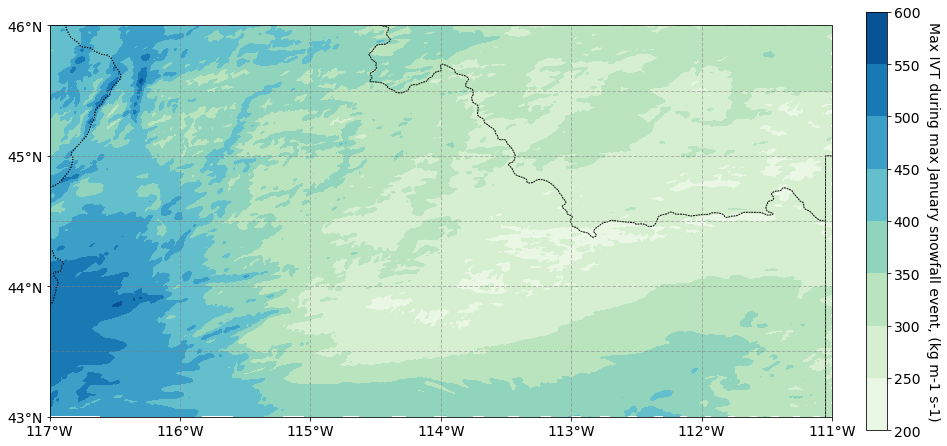

In [28]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(IVT_jan)

# Setup figure and projection
fig = plt.figure(figsize = (15,8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, IVT_jan[MaxSnowfallTimesStart:MaxSnowfallTimesEnd].max('time'), cmap=get_cmap("GnBu"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
ax.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
ax.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax.set_ylim([43,46])
ax.set_xlim([-117,-111])

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Max IVT during max January snowfall event, (kg m-1 s-1)", fontsize = 14, 
               rotation = 270, labelpad = 20)

# Add (a) or (b) text
# plt.text(-111.25, 45.82, "(a)", fontsize = 16, weight = 'bold')

plt.show()

- **Mean Monthly Plots**

    - Oct

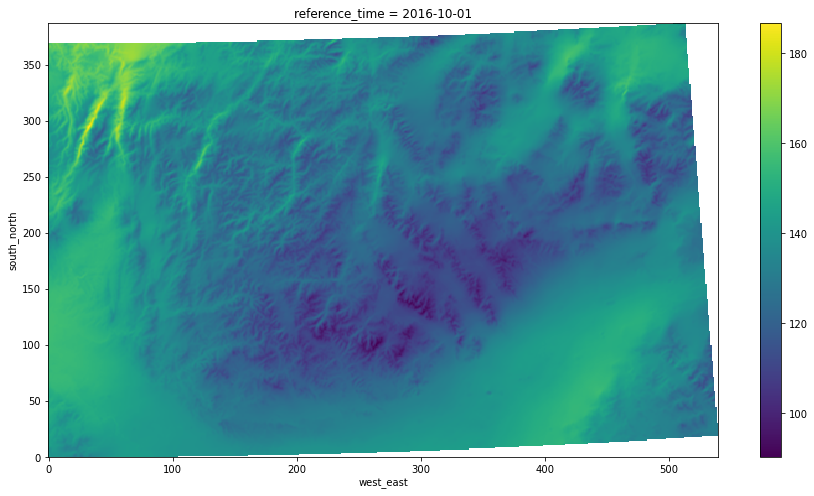

In [29]:
IVT_oct.mean('time').plot(figsize = (15,8));

    - Nov

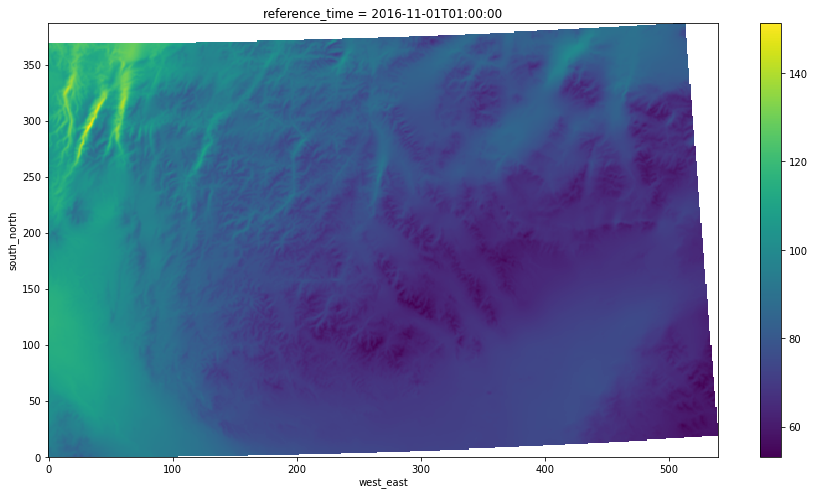

In [30]:
IVT_nov.mean('time').plot(figsize = (15,8));

    - Dec

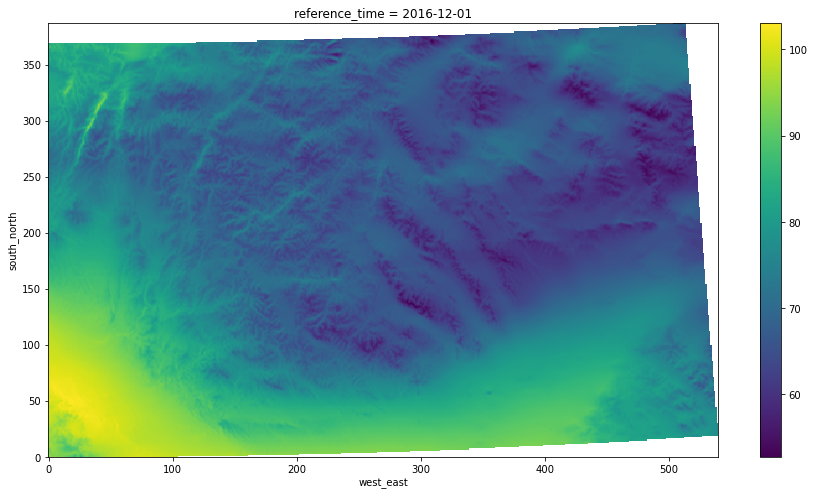

In [31]:
IVT_dec.mean('time').plot(figsize = (15,8));

    - Jan

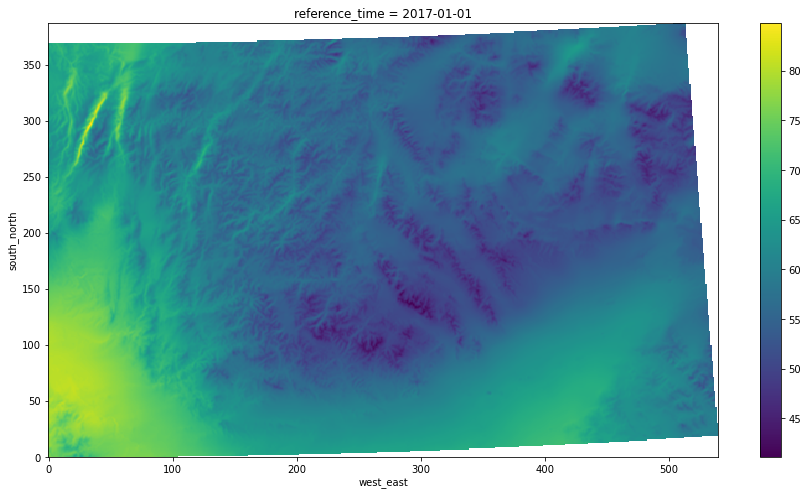

In [32]:
IVT_jan.mean('time').plot(figsize = (15,8));

    - Feb

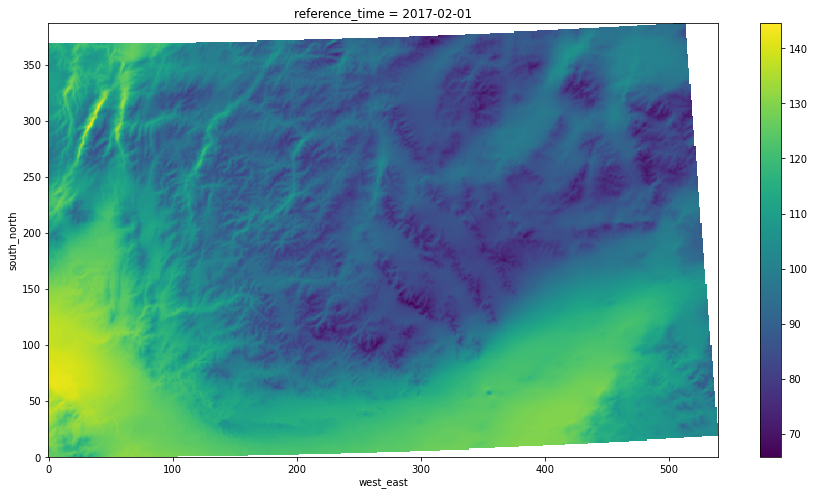

In [33]:
IVT_feb.mean('time').plot(figsize = (15,8));

    - Mar

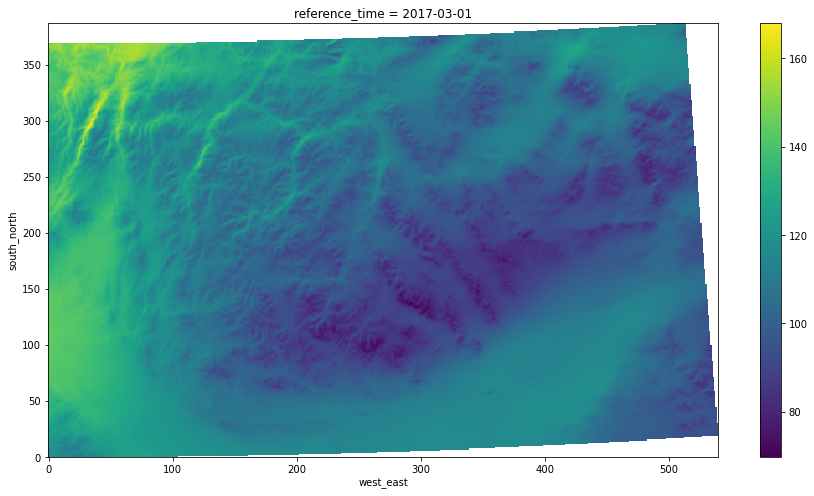

In [34]:
IVT_mar.mean('time').plot(figsize = (15,8));

    - Apr

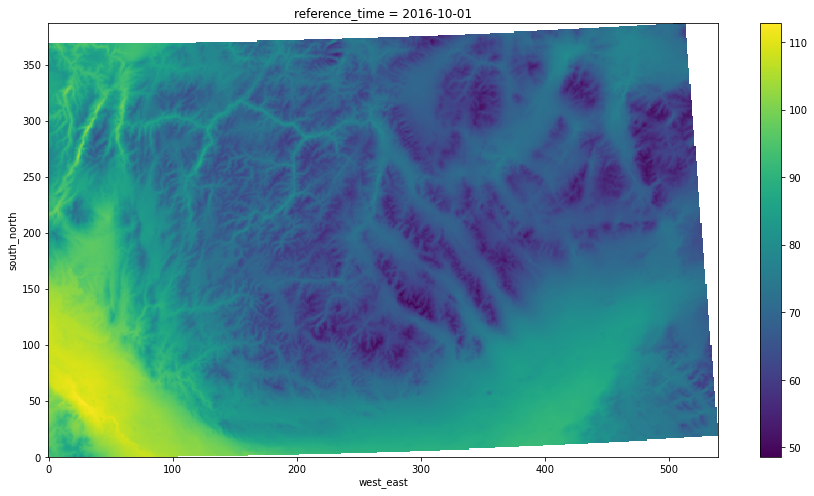

In [35]:
IVT_apr.mean('time').plot(figsize = (15,8));

- Monthly Event Means vs. Monthly Non-Event Means

In [36]:
IVT_events_monthly[0].max(), IVT_events_monthly[1].max(), IVT_events_monthly[2].max(), IVT_events_monthly[3].max(), IVT_events_monthly[4].max(), IVT_events_monthly[5].max(), IVT_events_monthly[6].max()

(<xarray.DataArray ()>
 array(191.98861547)
 Coordinates:
     time     datetime64[ns] 2016-10-31,
 <xarray.DataArray ()>
 array(139.37144348)
 Coordinates:
     time     datetime64[ns] 2016-11-30,
 <xarray.DataArray ()>
 array(153.56743455)
 Coordinates:
     time     datetime64[ns] 2016-12-31,
 <xarray.DataArray ()>
 array(122.42627176)
 Coordinates:
     time     datetime64[ns] 2017-01-31,
 <xarray.DataArray ()>
 array(172.43429623)
 Coordinates:
     time     datetime64[ns] 2017-02-28,
 <xarray.DataArray ()>
 array(161.96939078)
 Coordinates:
     time     datetime64[ns] 2017-03-31,
 <xarray.DataArray ()>
 array(116.97272567)
 Coordinates:
     time     datetime64[ns] 2017-04-30)

In [37]:
IVT_events_monthly[0].min(), IVT_events_monthly[1].min(), IVT_events_monthly[2].min(), IVT_events_monthly[3].min(), IVT_events_monthly[4].min(), IVT_events_monthly[5].min(), IVT_events_monthly[6].min()

(<xarray.DataArray ()>
 array(82.2908712)
 Coordinates:
     time     datetime64[ns] 2016-10-31,
 <xarray.DataArray ()>
 array(67.76671934)
 Coordinates:
     time     datetime64[ns] 2016-11-30,
 <xarray.DataArray ()>
 array(63.51221311)
 Coordinates:
     time     datetime64[ns] 2016-12-31,
 <xarray.DataArray ()>
 array(52.02151274)
 Coordinates:
     time     datetime64[ns] 2017-01-31,
 <xarray.DataArray ()>
 array(77.69034278)
 Coordinates:
     time     datetime64[ns] 2017-02-28,
 <xarray.DataArray ()>
 array(75.46466972)
 Coordinates:
     time     datetime64[ns] 2017-03-31,
 <xarray.DataArray ()>
 array(47.57417003)
 Coordinates:
     time     datetime64[ns] 2017-04-30)

In [38]:
IVT_events_monthly[0].mean(), IVT_events_monthly[1].mean(), IVT_events_monthly[2].mean(), IVT_events_monthly[3].mean(), IVT_events_monthly[4].mean(), IVT_events_monthly[5].mean(), IVT_events_monthly[6].mean()

(<xarray.DataArray ()>
 array(131.11559089)
 Coordinates:
     time     datetime64[ns] 2016-10-31,
 <xarray.DataArray ()>
 array(97.2035149)
 Coordinates:
     time     datetime64[ns] 2016-11-30,
 <xarray.DataArray ()>
 array(103.06455743)
 Coordinates:
     time     datetime64[ns] 2016-12-31,
 <xarray.DataArray ()>
 array(81.6935655)
 Coordinates:
     time     datetime64[ns] 2017-01-31,
 <xarray.DataArray ()>
 array(122.0541877)
 Coordinates:
     time     datetime64[ns] 2017-02-28,
 <xarray.DataArray ()>
 array(117.95878675)
 Coordinates:
     time     datetime64[ns] 2017-03-31,
 <xarray.DataArray ()>
 array(75.80141965)
 Coordinates:
     time     datetime64[ns] 2017-04-30)

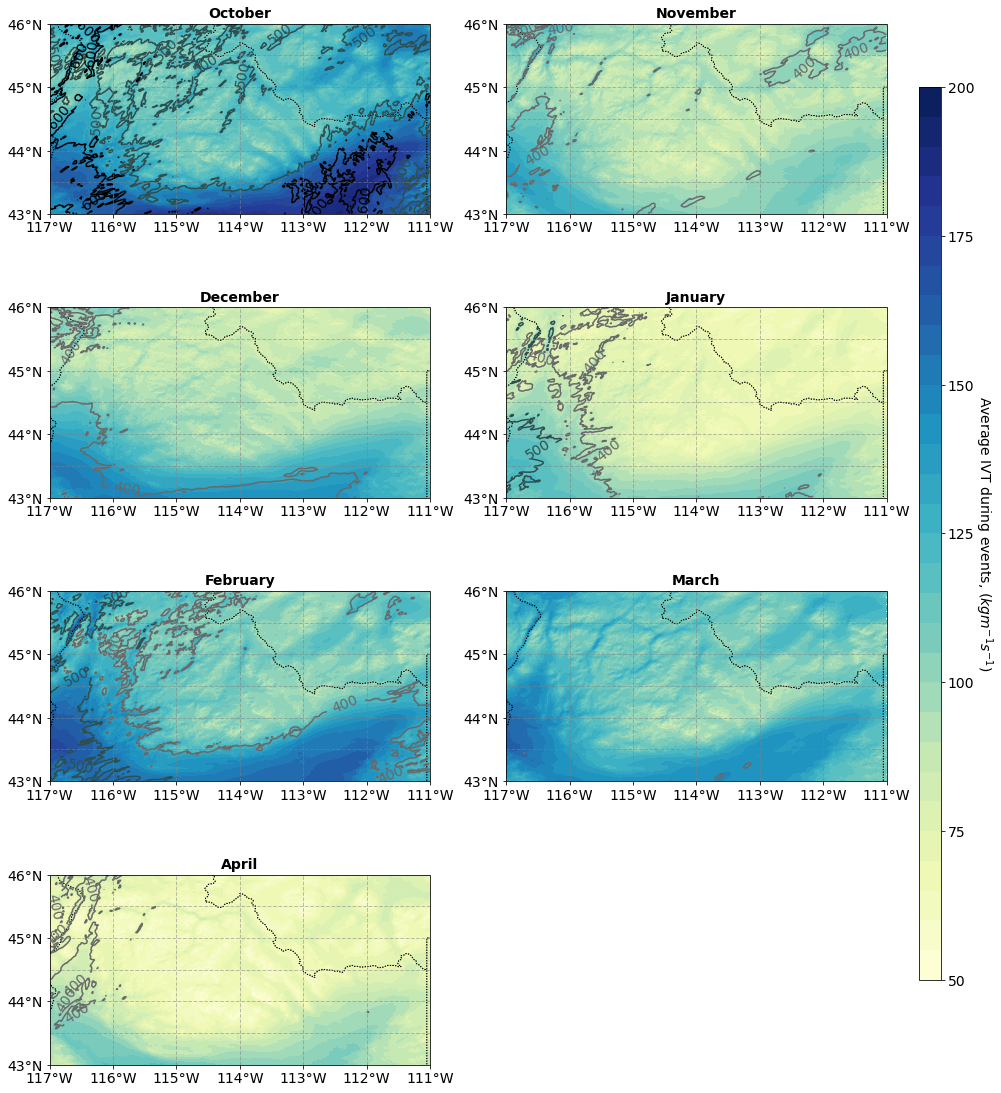

In [66]:
fig = plt.figure(figsize = [15,20])
ax1 = fig.add_subplot(4,2,1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(4,2,2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(4,2,3, projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(4,2,4, projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(4,2,5, projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(4,2,6, projection=ccrs.PlateCarree())
ax7 = fig.add_subplot(4,2,7, projection=ccrs.PlateCarree())

# Contour levels
levels = np.arange(50,205,5).tolist()
levels2 = np.arange(400,600,100).tolist()
levels3 = np.arange(500,700,100).tolist()
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(IVT_jan)

# Add state lines
ax1.add_feature(cfeature.STATES, linestyle=':')
ax2.add_feature(cfeature.STATES, linestyle=':')
ax3.add_feature(cfeature.STATES, linestyle=':')
ax4.add_feature(cfeature.STATES, linestyle=':')
ax5.add_feature(cfeature.STATES, linestyle=':')
ax6.add_feature(cfeature.STATES, linestyle=':')
ax7.add_feature(cfeature.STATES, linestyle=':')

# Contour of Events
cs1 = ax1.contourf(lons, lats, IVT_events_monthly[0], cmap=get_cmap("YlGnBu"), vmin = 50,
                 levels = levels, transform = ccrs.PlateCarree())
cs2 = ax2.contourf(lons, lats, IVT_events_monthly[1], cmap=get_cmap("YlGnBu"), vmin = 50,
                 levels = levels, transform = ccrs.PlateCarree())
cs3 = ax3.contourf(lons, lats, IVT_events_monthly[2], cmap=get_cmap("YlGnBu"), vmin = 50,
                 levels = levels, transform = ccrs.PlateCarree())
cs4 = ax4.contourf(lons, lats, IVT_events_monthly[3], cmap=get_cmap("YlGnBu"), vmin = 50,
                 levels = levels, transform = ccrs.PlateCarree())
cs5 = ax5.contourf(lons, lats, IVT_events_monthly[4], cmap=get_cmap("YlGnBu"), vmin = 50,
                 levels = levels, transform = ccrs.PlateCarree())
cs6 = ax6.contourf(lons, lats, IVT_events_monthly[5], cmap=get_cmap("YlGnBu"), vmin = 50,
                 levels = levels, transform = ccrs.PlateCarree())
cs7 = ax7.contourf(lons, lats, IVT_events_monthly[6], cmap=get_cmap("YlGnBu"), vmin = 50,
                 levels = levels, transform = ccrs.PlateCarree())

# Contour of Non-Events
cs11 = ax1.contour(lons, lats, IVT_events_max_monthly[0], colors = ['darkslategray', 'black'], #cmap=get_cmap("Greys"),
                 levels = levels3, transform = ccrs.PlateCarree())
cs21 = ax2.contour(lons, lats, IVT_events_max_monthly[1], colors = ['dimgray', 'darkslategray'], #cmap=get_cmap("Greys"),
                 levels = levels2, transform = ccrs.PlateCarree())
cs31 = ax3.contour(lons, lats, IVT_events_max_monthly[2], colors = ['dimgray', 'darkslategray'], #cmap=get_cmap("Greys"),
                 levels = levels2, transform = ccrs.PlateCarree())
cs41 = ax4.contour(lons, lats, IVT_events_max_monthly[3], colors = ['dimgray', 'darkslategray'],  #cmap=get_cmap("Greys"),
                 levels = levels2, transform = ccrs.PlateCarree())
cs51 = ax5.contour(lons, lats, IVT_events_max_monthly[4], colors = ['dimgray', 'darkslategray'], #cmap=get_cmap("Greys"),
                 levels = levels2, transform = ccrs.PlateCarree())
cs61 = ax6.contour(lons, lats, IVT_events_max_monthly[5], colors = ['dimgray', 'darkslategray'],#cmap=get_cmap("Greys"),
                 levels = levels2, transform = ccrs.PlateCarree())
cs71 = ax7.contour(lons, lats, IVT_events_max_monthly[6], colors = ['dimgray', 'darkslategray'],#cmap=get_cmap("Greys"),
                 levels = levels2, transform = ccrs.PlateCarree())


ax1.clabel(cs11, cs11.levels, inline=True, inline_spacing = 7, fontsize=14)
ax2.clabel(cs21, cs21.levels, inline=True, inline_spacing = 7, fontsize=14)
ax3.clabel(cs31, cs31.levels, inline=True, inline_spacing = 7, fontsize=14)
ax4.clabel(cs41, cs41.levels, inline=True, inline_spacing = 7, fontsize=14)
ax5.clabel(cs51, cs51.levels, inline=True, inline_spacing = 7, fontsize=14)
ax6.clabel(cs61, cs61.levels, inline=True, inline_spacing = 7, fontsize=14)
ax7.clabel(cs71, cs71.levels, inline=True, inline_spacing = 7, fontsize=14)

# Define the xticks for longitude
ax1.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax2.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax3.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax4.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax5.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax6.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax7.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())

lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax2.xaxis.set_major_formatter(lon_formatter)
ax3.xaxis.set_major_formatter(lon_formatter)
ax4.xaxis.set_major_formatter(lon_formatter)
ax5.xaxis.set_major_formatter(lon_formatter)
ax6.xaxis.set_major_formatter(lon_formatter)
ax7.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax1.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax5.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax6.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)

# Increase x and ytick label size
ax1.tick_params(labelsize = 14)
ax2.tick_params(labelsize = 14)
ax3.tick_params(labelsize = 14)
ax4.tick_params(labelsize = 14)
ax5.tick_params(labelsize = 14)
ax6.tick_params(labelsize = 14)
ax7.tick_params(labelsize = 14)

# Add lat/lon Gridlines
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax1.set_ylim([43,46])
ax1.set_xlim([-117,-111])
ax2.set_ylim([43,46])
ax2.set_xlim([-117,-111])
ax3.set_ylim([43,46])
ax3.set_xlim([-117,-111])
ax4.set_ylim([43,46])
ax4.set_xlim([-117,-111])
ax5.set_ylim([43,46])
ax5.set_xlim([-117,-111])
ax6.set_ylim([43,46])
ax6.set_xlim([-117,-111])
ax7.set_ylim([43,46])
ax7.set_xlim([-117,-111])

# Figure Labels
ax1.set_title('October', fontsize = 14, weight = 'bold')
ax2.set_title('November', fontsize = 14, weight = 'bold')
ax3.set_title('December', fontsize = 14, weight = 'bold')
ax4.set_title('January', fontsize = 14, weight = 'bold')
ax5.set_title('February', fontsize = 14, weight = 'bold')
ax6.set_title('March', fontsize = 14, weight = 'bold')
ax7.set_title('April', fontsize = 14, weight = 'bold')

# Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.62])
cbar = fig.colorbar(cs1, cax=cbar_ax, ticks = np.arange(50,225,25).tolist())
cbar.set_label(label = "Average IVT during events, ($kg m^{-1}s^{-1}$)", fontsize = 14,
              rotation = 270, labelpad = 20)
cbar.ax.tick_params(labelsize=14)

plt.show()

- Monthly Event Maxes

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/ipykernel_launcher.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


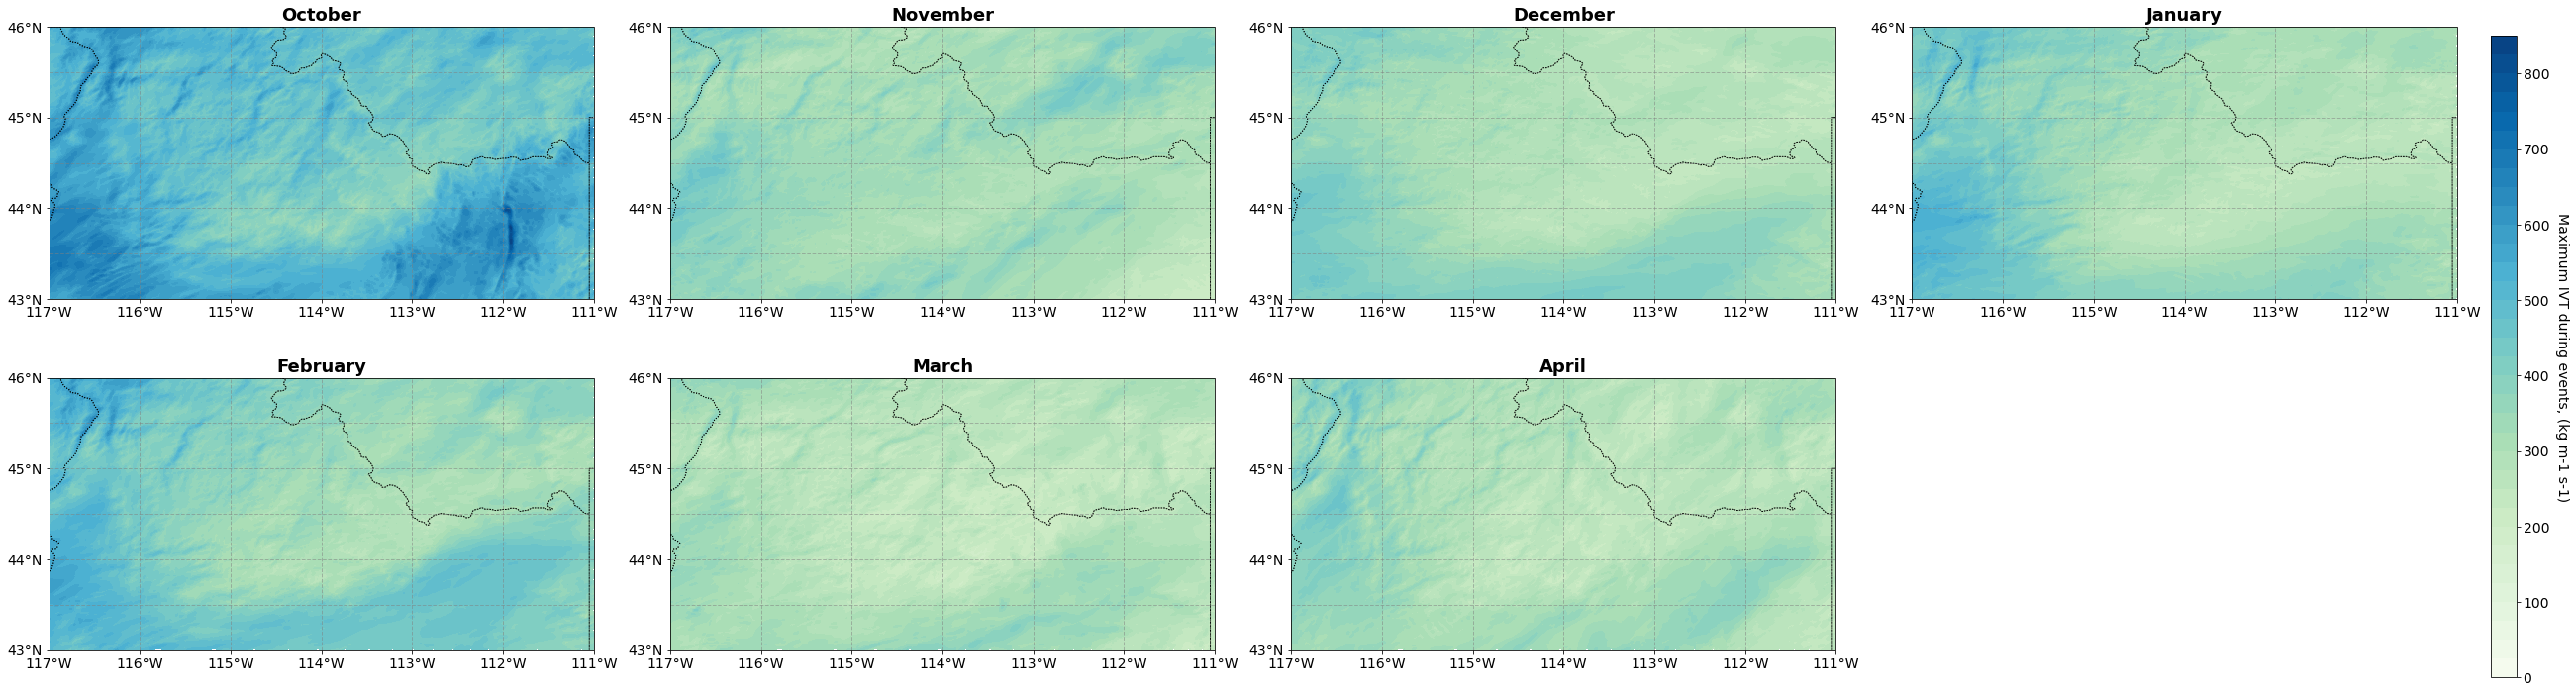

In [43]:
fig = plt.figure(figsize = [35,10])
ax1 = fig.add_subplot(2,4,1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2,4,2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(2,4,3, projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(2,4,4, projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(2,4,5, projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(2,4,6, projection=ccrs.PlateCarree())
ax7 = fig.add_subplot(2,4,7, projection=ccrs.PlateCarree())

# Contour levels
levels = np.arange(0,875,25).tolist()
levels2 = np.arange(0,225,25).tolist()

# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(IVT_jan)

# Add state lines
ax1.add_feature(cfeature.STATES, linestyle=':')
ax2.add_feature(cfeature.STATES, linestyle=':')
ax3.add_feature(cfeature.STATES, linestyle=':')
ax4.add_feature(cfeature.STATES, linestyle=':')
ax5.add_feature(cfeature.STATES, linestyle=':')
ax6.add_feature(cfeature.STATES, linestyle=':')
ax7.add_feature(cfeature.STATES, linestyle=':')

# Contour of Events
cs1 = ax1.contourf(lons, lats, IVT_events_max_monthly[0], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())
cs2 = ax2.contourf(lons, lats, IVT_events_max_monthly[1], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())
cs3 = ax3.contourf(lons, lats, IVT_events_max_monthly[2], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())
cs4 = ax4.contourf(lons, lats, IVT_events_max_monthly[3], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())
cs5 = ax5.contourf(lons, lats, IVT_events_max_monthly[4], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())
cs6 = ax6.contourf(lons, lats, IVT_events_max_monthly[5], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())
cs7 = ax7.contourf(lons, lats, IVT_events_max_monthly[6], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())

# # Contour of Non-Events
# cs11 = ax1.contour(lons, lats, IVT_non_events_monthly[0], colors = 'darkmagenta', #cmap=get_cmap("Greys"),
#                  levels = levels2, transform = ccrs.PlateCarree())
# cs21 = ax2.contour(lons, lats, IVT_non_events_monthly[1], colors = 'darkmagenta',#cmap=get_cmap("Greys"),
#                  levels = levels2, transform = ccrs.PlateCarree())
# cs31 = ax3.contour(lons, lats, IVT_non_events_monthly[2], colors = 'darkmagenta', #cmap=get_cmap("Greys"),
#                  levels = levels2, transform = ccrs.PlateCarree())
# cs41 = ax4.contour(lons, lats, IVT_non_events_monthly[3], colors = 'darkmagenta',  #cmap=get_cmap("Greys"),
#                  levels = levels2, transform = ccrs.PlateCarree())
# cs51 = ax5.contour(lons, lats, IVT_non_events_monthly[4], colors = 'darkmagenta',#cmap=get_cmap("Greys"),
#                  levels = levels2, transform = ccrs.PlateCarree())
# cs61 = ax6.contour(lons, lats, IVT_non_events_monthly[5], colors = 'darkmagenta', #cmap=get_cmap("Greys"),
#                  levels = levels2, transform = ccrs.PlateCarree())
# cs71 = ax7.contour(lons, lats, IVT_non_events_monthly[6], colors = 'darkmagenta', #cmap=get_cmap("Greys"),
#                  levels = levels2, transform = ccrs.PlateCarree())

ax1.clabel(cs11, cs11.levels, inline=True, inline_spacing = 7, fontsize=14)
ax2.clabel(cs21, cs21.levels, inline=True, inline_spacing = 7, fontsize=14)
ax3.clabel(cs31, cs31.levels, inline=True, inline_spacing = 7, fontsize=14)
ax4.clabel(cs41, cs41.levels, inline=True, inline_spacing = 7, fontsize=14)
ax5.clabel(cs51, cs51.levels, inline=True, inline_spacing = 7, fontsize=14)
ax6.clabel(cs61, cs61.levels, inline=True, inline_spacing = 7, fontsize=14)
ax7.clabel(cs71, cs71.levels, inline=True, inline_spacing = 7, fontsize=14)

# Define the xticks for longitude
ax1.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax2.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax3.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax4.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax5.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax6.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
ax7.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())

lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax2.xaxis.set_major_formatter(lon_formatter)
ax3.xaxis.set_major_formatter(lon_formatter)
ax4.xaxis.set_major_formatter(lon_formatter)
ax5.xaxis.set_major_formatter(lon_formatter)
ax6.xaxis.set_major_formatter(lon_formatter)
ax7.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax1.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax5.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax6.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)

# Increase x and ytick label size
ax1.tick_params(labelsize = 14)
ax2.tick_params(labelsize = 14)
ax3.tick_params(labelsize = 14)
ax4.tick_params(labelsize = 14)
ax5.tick_params(labelsize = 14)
ax6.tick_params(labelsize = 14)
ax7.tick_params(labelsize = 14)

# Add lat/lon Gridlines
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax1.set_ylim([43,46])
ax1.set_xlim([-117,-111])
ax2.set_ylim([43,46])
ax2.set_xlim([-117,-111])
ax3.set_ylim([43,46])
ax3.set_xlim([-117,-111])
ax4.set_ylim([43,46])
ax4.set_xlim([-117,-111])
ax5.set_ylim([43,46])
ax5.set_xlim([-117,-111])
ax6.set_ylim([43,46])
ax6.set_xlim([-117,-111])
ax7.set_ylim([43,46])
ax7.set_xlim([-117,-111])

# Figure Labels
ax1.set_title('October', fontsize = 18, weight = 'bold')
ax2.set_title('November', fontsize = 18, weight = 'bold')
ax3.set_title('December', fontsize = 18, weight = 'bold')
ax4.set_title('January', fontsize = 18, weight = 'bold')
ax5.set_title('February', fontsize = 18, weight = 'bold')
ax6.set_title('March', fontsize = 18, weight = 'bold')
ax7.set_title('April', fontsize = 18, weight = 'bold')

# Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1.0, 0.025, 0.01, 0.9])
cbar = fig.colorbar(cs1, cax=cbar_ax)
cbar.set_label(label = "Maximum IVT during events, (kg m-1 s-1)", fontsize = 14,
              rotation = 270, labelpad = 20)
cbar.ax.tick_params(labelsize=14)

# Adjust Layout
fig.tight_layout()

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.25, 
#                     hspace=0.33)

plt.show()